In [1]:
import os
from importlib import reload

import omrmodules
import torch
import cv2 as cv
import importlib

import numpy as np
from omrmodules.datasets.MuscimaMeasures import visualize_bboxes

from torchvision.utils import draw_bounding_boxes
from PIL import Image

def visualize(image, boxes):
    viz_image = (image*255).type(torch.ByteTensor)
    viz_boxes = omrmodules.semantics.SystemObjects.denormalize_bboxes(np.asarray(boxes), viz_image)
    viz_boxes = torch.asarray(viz_boxes)

    viz_im_with_bounding_boxes = draw_bounding_boxes(viz_image, viz_boxes, width=5, colors="red")

    Image.fromarray(np.moveaxis(viz_im_with_bounding_boxes.numpy(), 0, -1))



In [2]:

###
# preparation
IMAGE = os.path.join('..', 'samples', 'one_handed.jpg')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# load models
MODEL_MEASURE = os.path.join('..', 'saved_models', 'muscima_measures.pt')
MODEL_OBJECT = os.path.join('..', 'saved_models', 'muscima_objects_pitchonly.pt')
model_measures = torch.load(MODEL_MEASURE, map_location=torch.device('cpu'))
model_objects = torch.load(MODEL_OBJECT, map_location=torch.device('cpu'))
model_measures.to(device)
model_objects.to(device)
model_measures.eval()
model_objects.eval()
model_measures([torch.rand(1,400,400).to(device)])
model_objects([torch.rand(1,400,400).to(device)])
    
###
#

# read image
image = cv.imread(IMAGE)

# pre-process image
image = omrmodules.normalization.preprocess.processnotesheet(image)

# model inference
image = (np.expand_dims(image, 0) / 255.0).astype(np.float32)
image = [torch.from_numpy(image).to(device)]
measure_dict = model_measures(image)
object_dict = model_objects(image)

# pass results to SongFactory


In [17]:
import omrmodules.semantics.SystemObjects as SystemObjects
import omrmodules.semantics.SoundObjects as SoundObjects

reload(SystemObjects)
reload(SoundObjects)

<module 'omrmodules.semantics.SoundObjects' from 'c:\\repositories\\omrtorch\\omrmodules\\semantics\\SoundObjects.py'>

In [10]:
song = SystemObjects.SongFactory(image[0], measure_dict[0], object_dict[0]).song
staff1 = song.systems[0].staves[0]
measure1 = song.systems[0].measures[0]

In [11]:
measure1.__class__

omrmodules.semantics.SystemObjects.Measure

In [12]:
gap = staff1.getgap()
bottom = staff1.stats['bottom']

pose = measure1.toStream(bottom, gap)

In [20]:
import music21 as m21

In [ ]:
notes = []
for n in pose:
    notes.append(SoundObjects.getNote('gClef', n))

In [22]:
m21.stream.Measure(notes)


<music21.stream.Measure 0 offset=0.0>

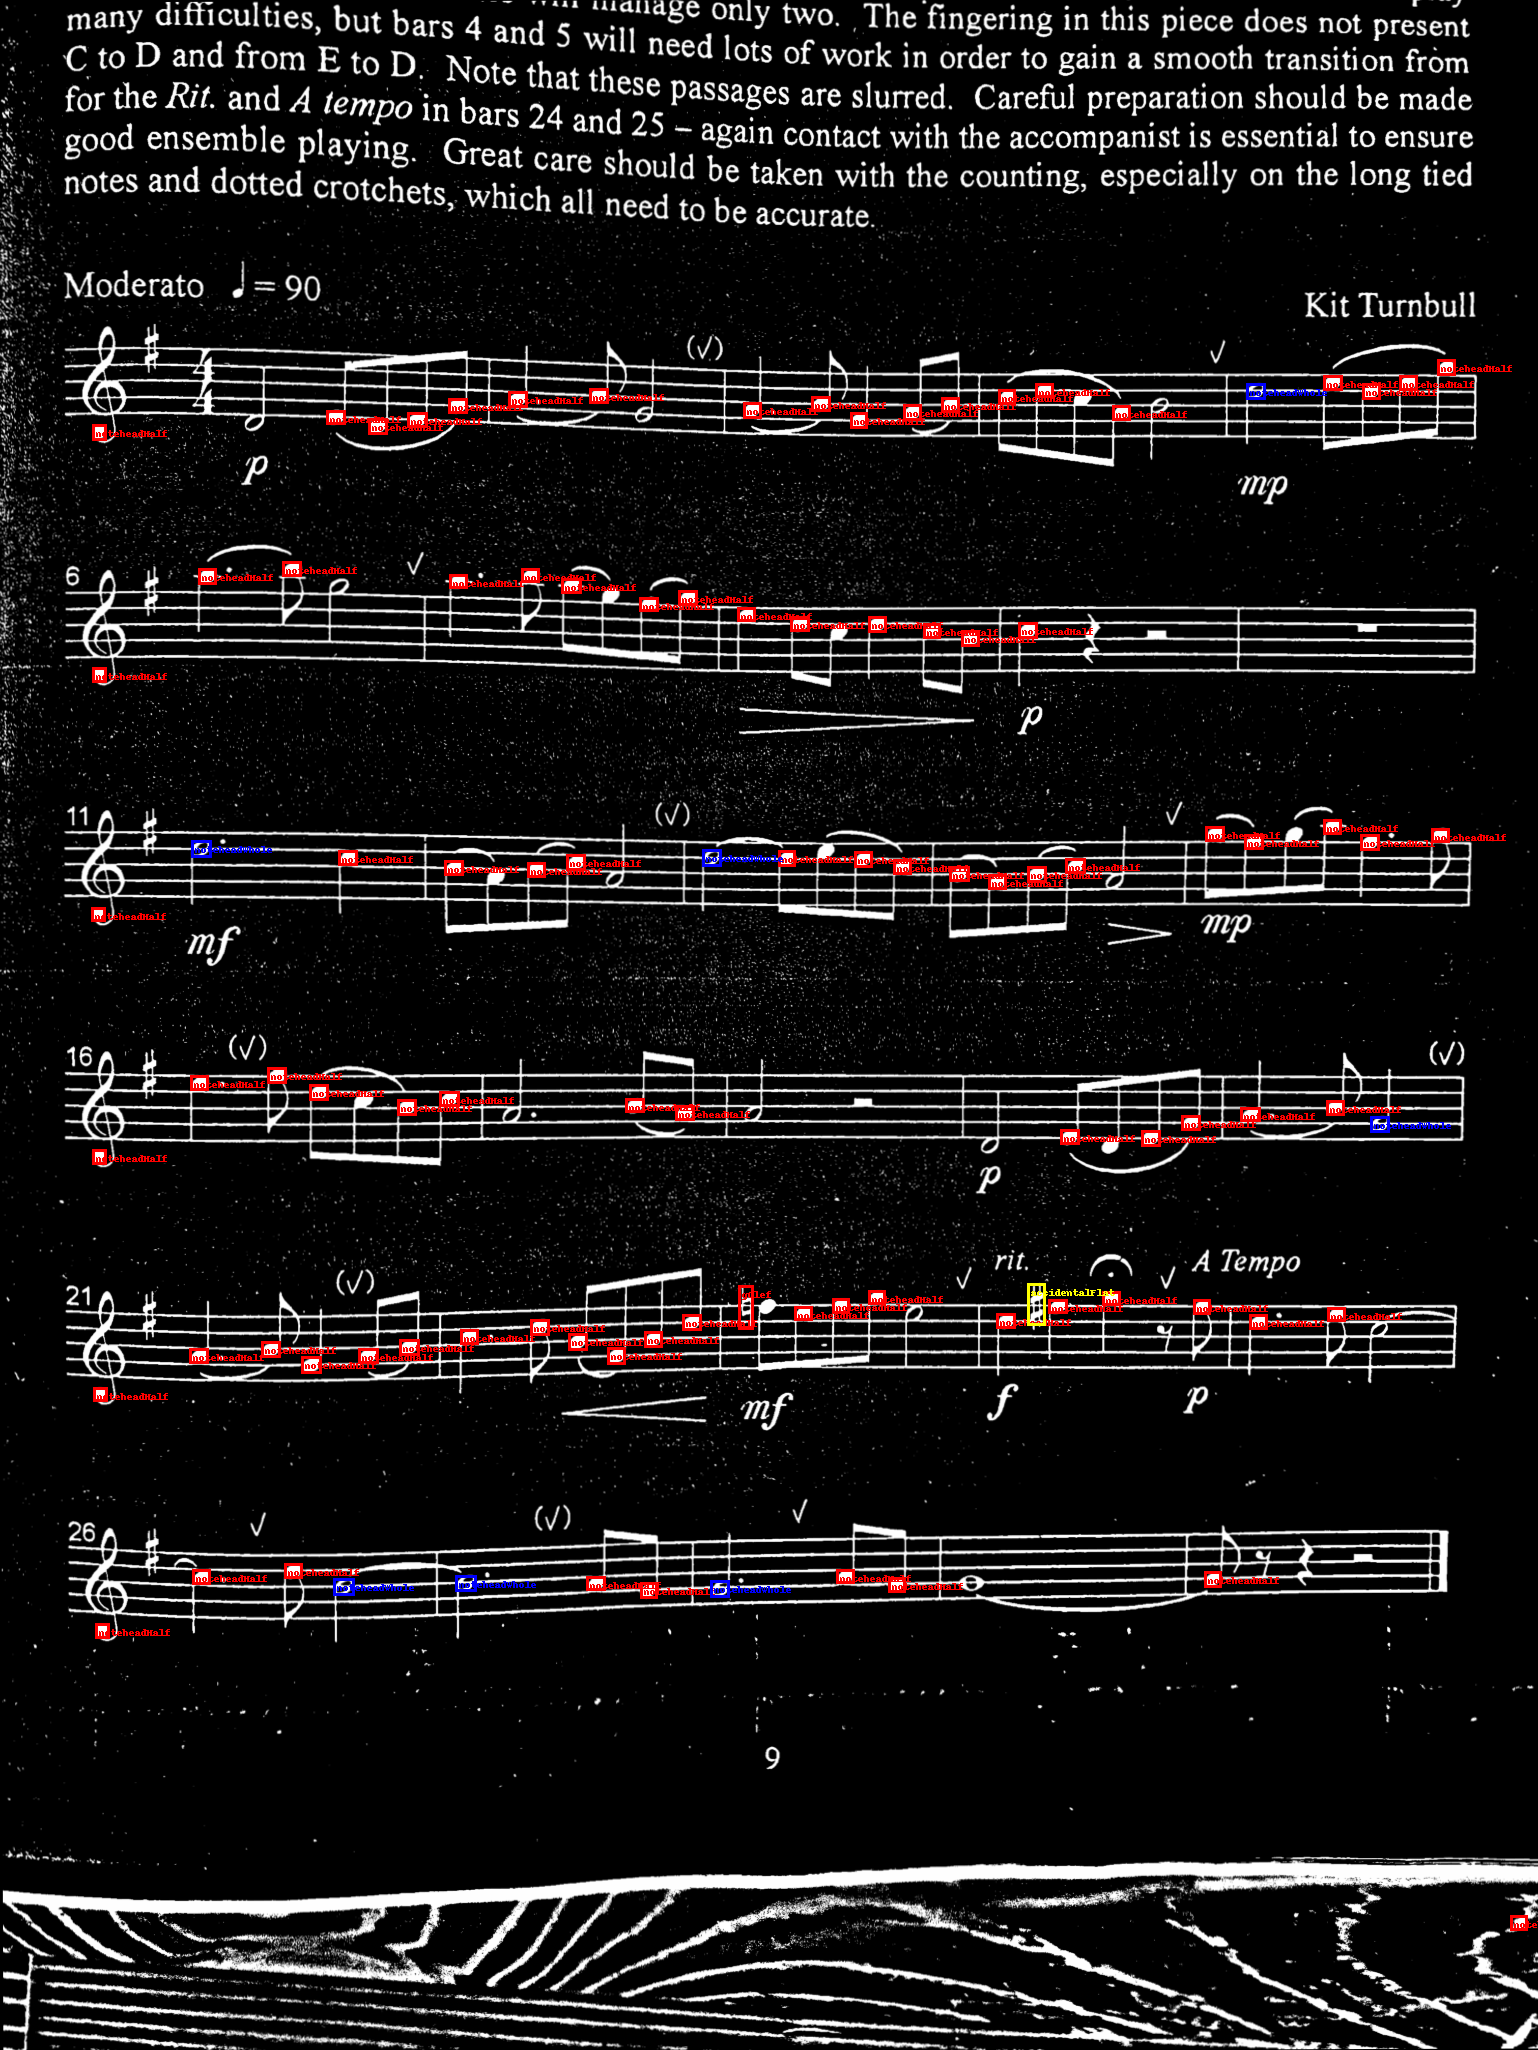

In [4]:
labels = omrmodules.semantics.SystemObjects.__pitch_objects__
visualize_bboxes(image[0], object_dict[0], labels, threshold=0.5)

In [ ]:
viz_im_with_bounding_boxes = draw_bounding_boxes(viz_image, viz_boxes, width=5, colors="red")

Image.fromarray(np.moveaxis(viz_im_with_bounding_boxes.numpy(), 0, -1))

In [39]:
importlib.reload(omrmodules.semantics.SystemObjects)

<module 'omrmodules.semantics.SystemObjects' from 'c:\\repositories\\omrtorch\\omrmodules\\semantics\\SystemObjects.py'>

In [29]:
he_wi = image[0].shape[1:3]
system_measures, staff_measures = SongFactory.process_measure_dict(measure_dict[0], he_wi)

In [30]:
songFactory = omrmodules.semantics.SystemObjects.SongFactory(image[0], measure_dict[0], object_dict[0])

song = songFactory.song

In [31]:

boxes = []
for system in song.systems:
    boxes.append(system.bbox())
    
omrmodules.semantics.SystemObjects.denormalize_bboxes(np.asarray(boxes), image[0])

array([[   0.        ,    0.        , 1538.        ,  519.31457836],
       [   0.        ,  519.31457836, 1538.        ,  752.37535164],
       [   0.        ,  752.37535164, 1538.        ,  987.75999397],
       [   0.        ,  987.75999397, 1538.        , 1221.19562179],
       [   0.        , 1221.19562179, 1538.        , 2050.        ]])

In [38]:
song.systems

In [33]:
boxes2 = []
for system in song.systems:
    for measure in system.measures:
        boxes2.append(measure.bbox())

In [36]:
from torchvision.utils import draw_bounding_boxes
from PIL import Image

def visualize(image, boxes):
    viz_image = (image*255).type(torch.ByteTensor)
    viz_boxes = omrmodules.semantics.SystemObjects.denormalize_bboxes(np.asarray(boxes), viz_image)
    viz_boxes = torch.asarray(viz_boxes)

    viz_im_with_bounding_boxes = draw_bounding_boxes(viz_image, viz_boxes, width=5, colors="red")

    return Image.fromarray(np.moveaxis(viz_im_with_bounding_boxes.numpy(), 0, -1))

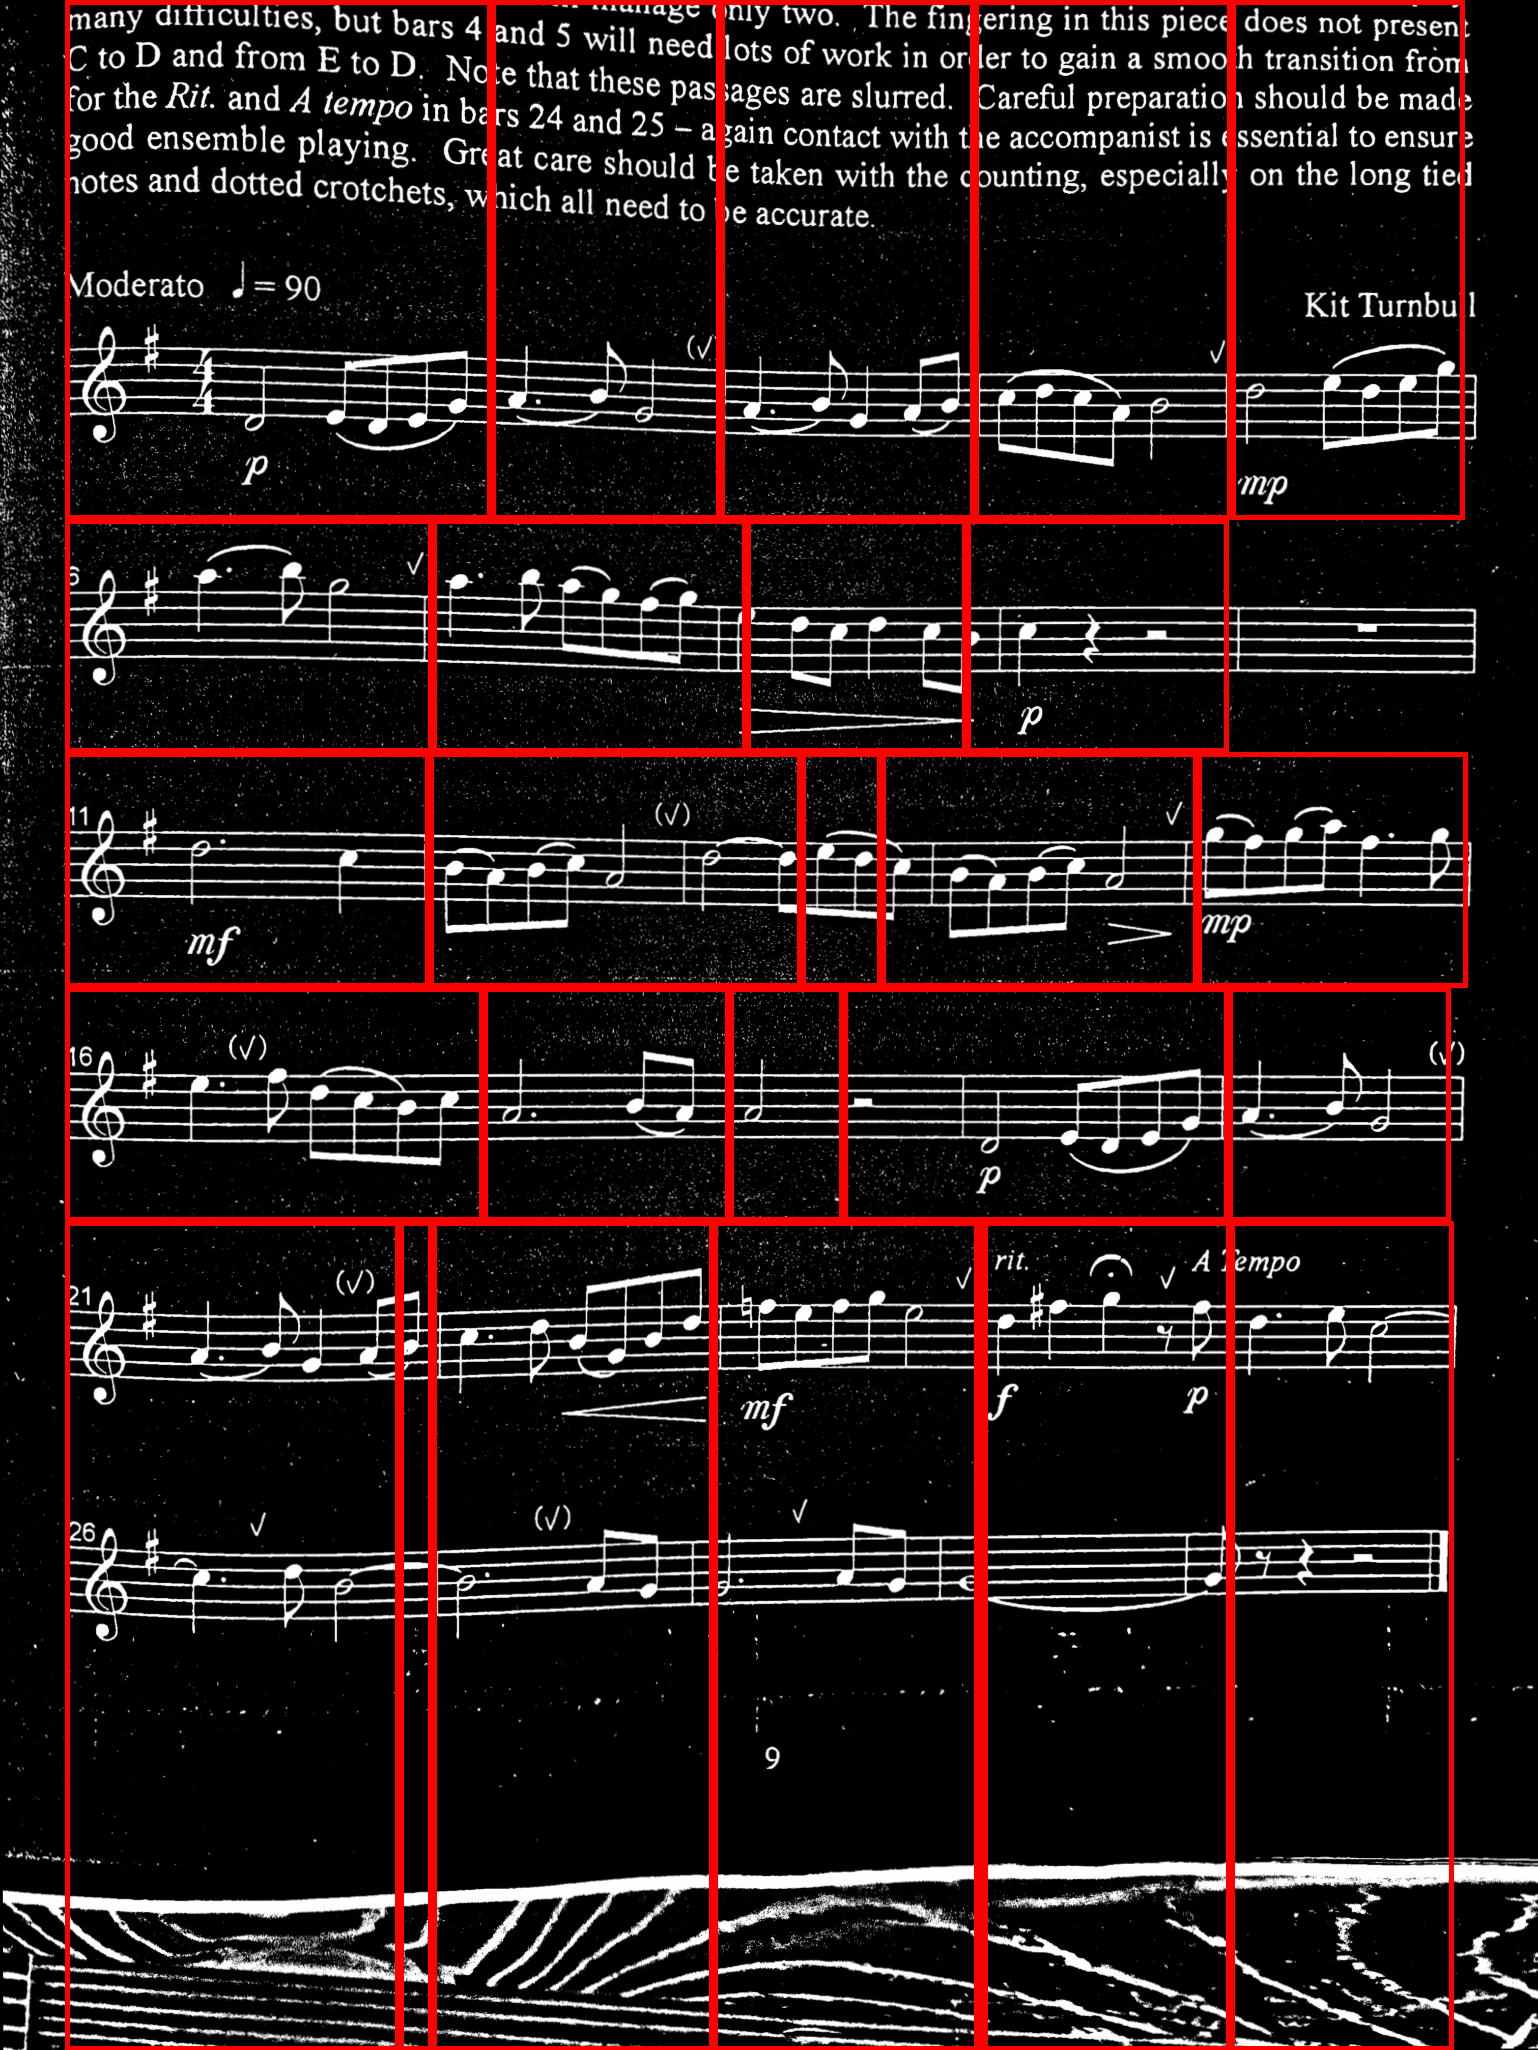

In [37]:
viz = visualize(song.image, boxes2)


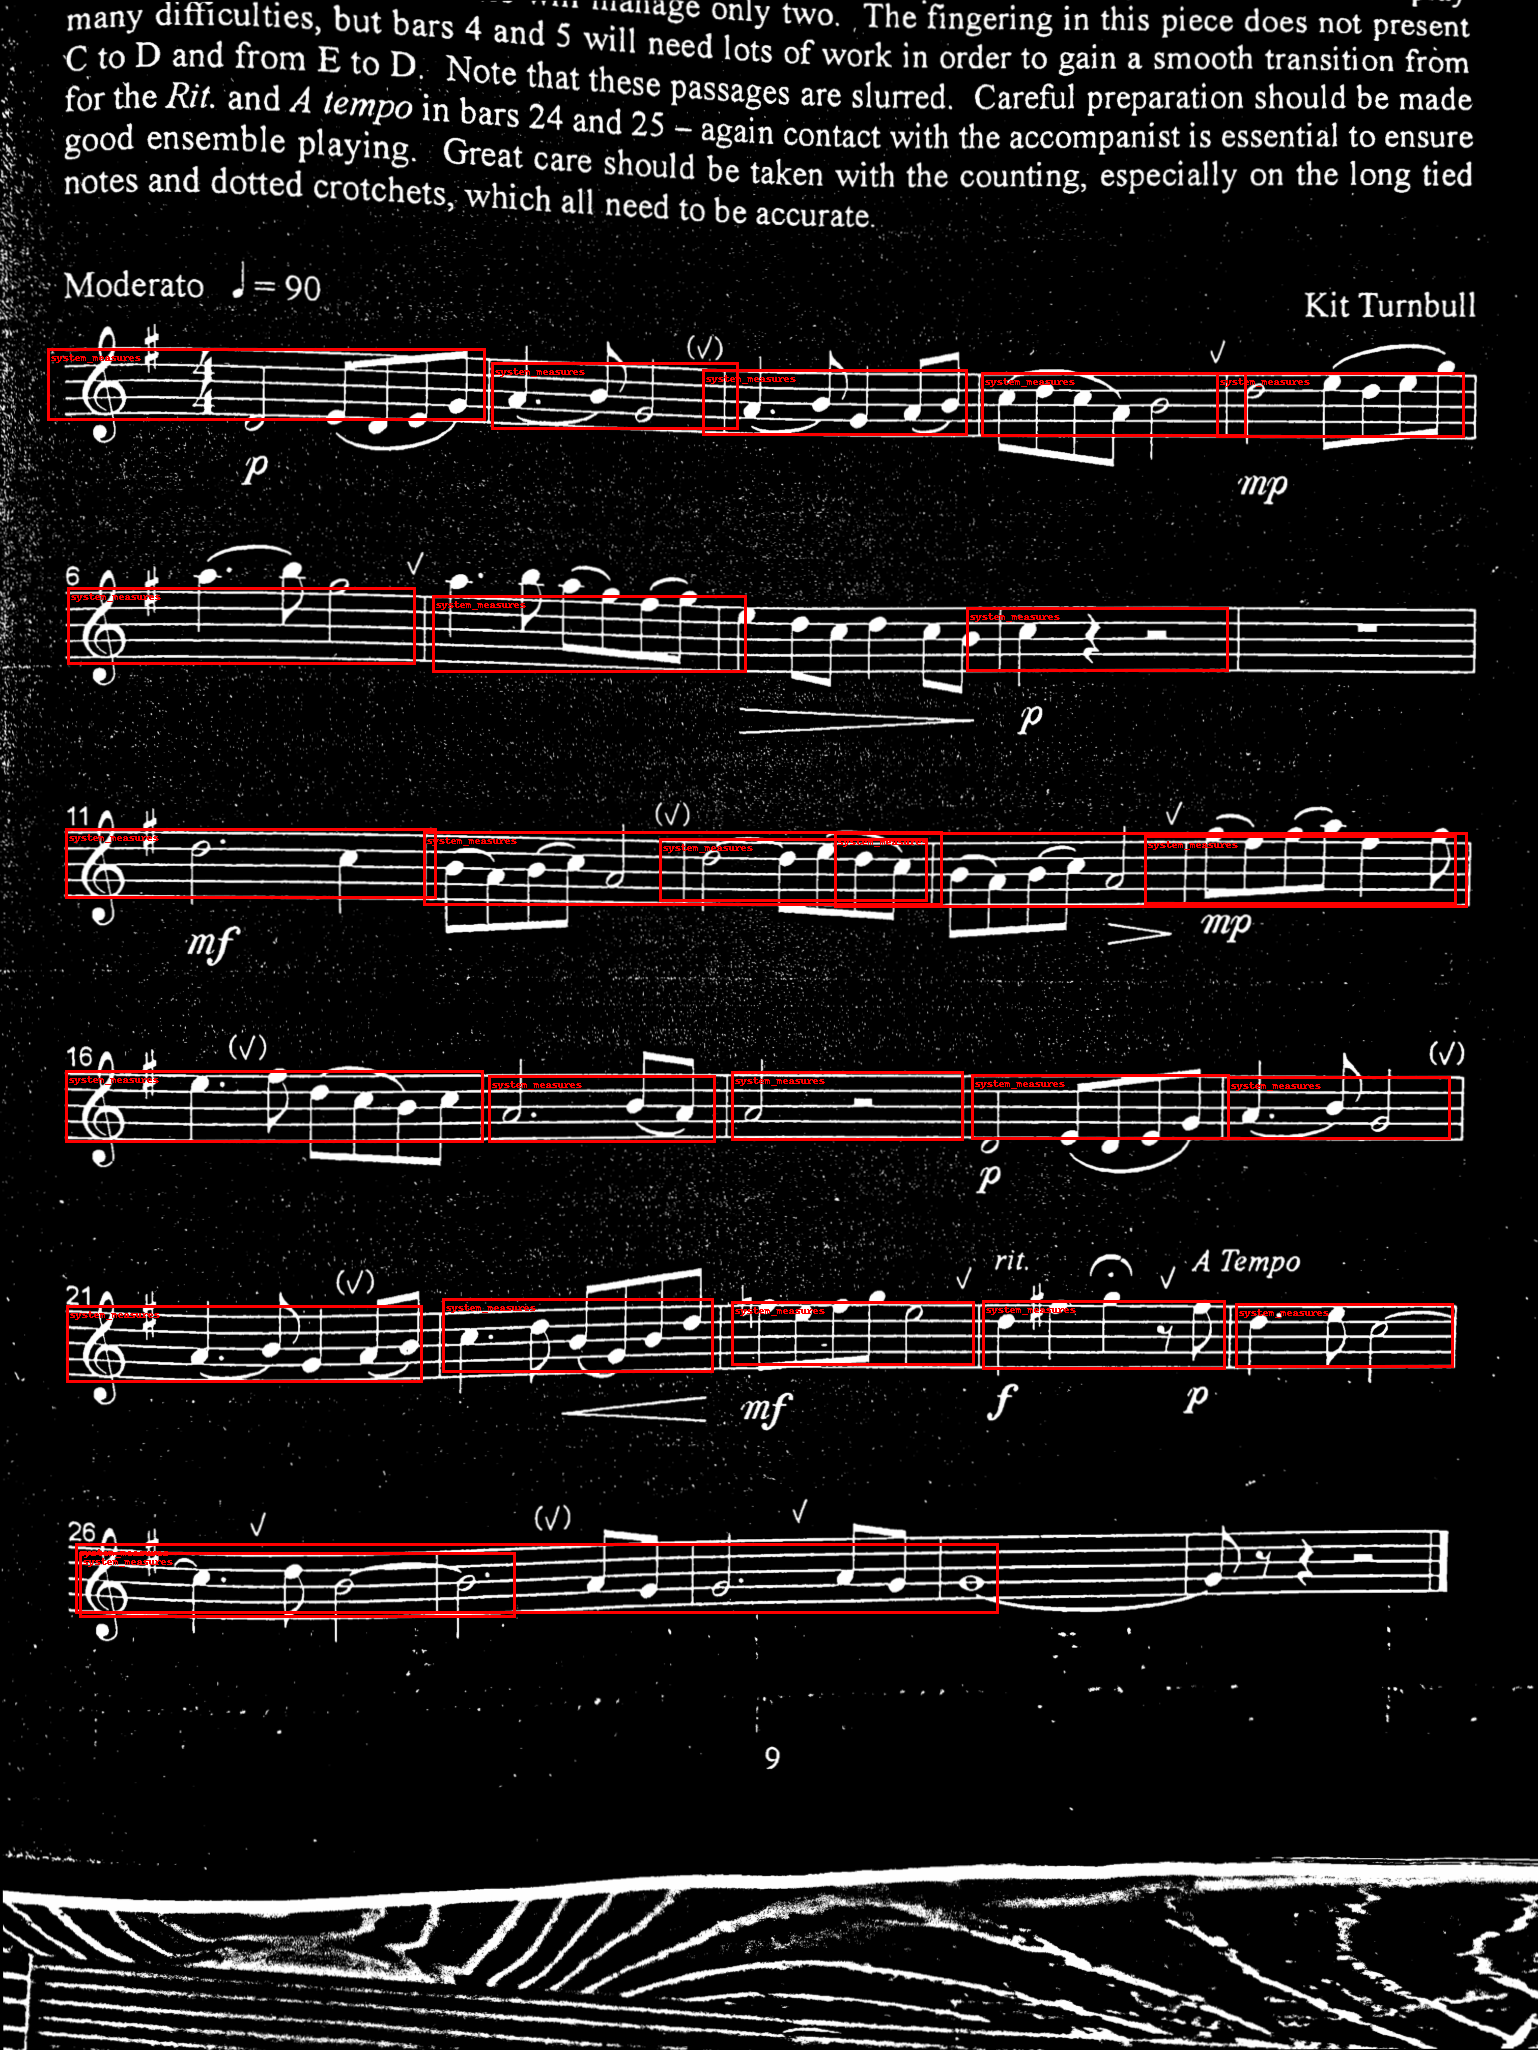

In [28]:
visualize_bboxes(image[0], measure_dict[0])

In [57]:
sbox = np.asarray(boxes2)
sort_order = np.argsort(sbox[:,1])
sbox = sbox[sort_order]

In [ ]:
# create a list of list of bboxes
groups = []
groups.append(np.expand_dims(sbox[0,:], axis=0))
top = np.average(groups[0][:,1])
bottom = np.average(groups[0][:,3])

In [ ]:
for box in sbox:
    center = (box[1] + box[3])/2
    if top < center < bottom:
        groups[0]([groups[0], np.expand_dims(box, 0)], axis=0)

    

ValueError: could not broadcast input array from shape (2,4) into shape (1,4)

In [ ]:
if top < center < bottom:
        groups[0] = np.vstack([groups[0], box])

In [ ]:
bottom

0.27799154818058014

In [58]:
staves = songFactory.staves

In [59]:
staves

In [60]:
grouped = [staff.measures for staff in staves]
ungrouped = np.vstack(grouped)
left_limit = np.min(ungrouped[:,0])
right_limit = np.max(ungrouped[:,2])
mingap = np.average(ungrouped[:,2] - ungrouped[:,0])/2


In [61]:
np.argsort(grouped[5][:,0])

array([0, 1], dtype=int64)

In [62]:
print(left_limit)
print(right_limit)

0.086606875
0.90205294


In [63]:
for gid, group in enumerate(grouped):
    top = np.average(group[:,1])
    bottom = np.average(group[:,3])
    for idx, measure in enumerate(group):
        if idx == 0: # check left of the first detection
            if measure[0] > left_limit + mingap:
                synth = [left_limit, top, measure[0], bottom]
                grouped[gid] = np.vstack([group, synth])
        if idx == len(group) - 1: # check right of the last detection
            if measure[2] < right_limit - mingap:
                synth = [measure[2], top, right_limit, bottom]
                grouped[gid] = np.vstack([group, synth])
        else:
            if group[idx+1][0] - measure[2] > 0:
                synth = [measure[2], top, group[idx+1], bottom]
                grouped[gid] = np.vstack([group, synth])
for idx in range(len(staves)):
    staves[idx].measures = grouped[idx]
    staves[idx].measures.sort()


                
